In [1]:
import arcpy
import os
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
import pandas as pd
from skimage.transform import resize

arcpy.env.parallelProcessingFactor = "50%"
arcpy.env.pyramid = "NONE"
arcpy.env.rasterStatistics = 'NONE'
arcpy.SetLogMetadata(False)
arcpy.SetLogHistory(False)

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

ImportError: DLL load failed: Le module spécifié est introuvable.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Global variables

In [3]:
# ArcGIS variables
path = "H:/Python/arcpy_tensorflow/"
path_raster = "R:/SIGR/DonneesCommunes/FONDS/ORTHOPHOTO/ortho2021.gdb/orthophoto2021"
raster = arcpy.Raster(path_raster)
img_size = 500 # Size of the images you want to crop
pt_ref = arcpy.Point(657810,6867200)
resolution = 0.15 # Resolution of your raster in meters
shift = 100 # The gap between the origin of the original image and the shifted ones in pixels

# Model variables
name_model = "H:/Python/Classification/ChantierNet4.h5" # The name and/or path to where the weigths of your model are stored.
width, height = 250, 250 # Size of images for the model.
class_names = ["chantier_plein","chantier_vide"] # list of all the different class names that your model can predict
path_old_pred = "H:/predictions/chantiers/chantiers_91.csv"
path_results = "H:/predictions/chantiers/newshift_chantiers_91.csv" # will store the predictions for each images in a .txt file

Functions

In [4]:
def time_it(func):
    """ Usage : Put @time_it before your function to calculate execution time. """
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Execution time of {func.__name__}: {end - start:.5f} seconds")
        return result
    return wrapper

In [33]:
def processing(array):
    array = array.T
    array = np.rot90(array,k=-1)
    array = np.flip(array,axis=1)
    array = resize(array,(width,height)) # resizing for the model
    # Converting to jpg
    im = Image.fromarray((array*255).astype('uint8'), 'RGB')
    array = np.array(im)
    return array

@time_it
def load_image(Coordx,Coordy,img_size=img_size,raster=raster):
    array = arcpy.RasterToNumPyArray(raster,arcpy.Point(Coordx,Coordy),img_size,img_size)
    array = processing(array)
    return array

def full_load(Coordx,Coordy,shifting,img_size=img_size,resolution=resolution,raster=raster):
    """
    Load an image and it's neighbouring images by shifting slightly the scope of capture.
    Inputs :
        - Coordx : The x coordinates on the raster
        - Coordy : The y coordinates on the raster
        - shifting : The gap between the origin of the original image and the shifted ones in pixels
        - img_size : The size of the image in output
        - resolution : The picture resolution of the raster
        - path_raster : The path to the raster you want to extract the images from
    Output :
        - A list of coordinates for each images.
        - An array containing arrays representing each image generated
    """
    res = []
    liste = []
    # Loading original image
    array = arcpy.RasterToNumPyArray(raster,arcpy.Point(Coordx,Coordy),img_size,img_size)
    array = processing(array)
    res.append(array)
    liste.append([Coordx,Coordy])
    # Shifting slightly towards the four cardinal directions
    if shifting > 0 : # If shifting is <= 0 no shifting is done
        # Droite
        dx = int(Coordx+shifting*resolution)
        dy = int(Coordy)
        array = arcpy.RasterToNumPyArray(raster,arcpy.Point(dx,dy),img_size,img_size)
        array = processing(array)
        res.append(array)
        liste.append([dx,dy])
        # Gauche
        dx = int(Coordx-shifting*resolution)
        dy = int(Coordy)
        array = arcpy.RasterToNumPyArray(raster,arcpy.Point(dx,dy),img_size,img_size)
        array = processing(array)
        res.append(array)
        liste.append([dx,dy])
        # Bas
        dx = int(Coordx)
        dy = int(Coordy-shifting*resolution)
        array = arcpy.RasterToNumPyArray(raster,arcpy.Point(dx,dy),img_size,img_size)
        array = processing(array)
        res.append(array)
        liste.append([dx,dy])
        # Haut
        dx = int(Coordx)
        dy = int(Coordy+shifting*resolution)
        array = arcpy.RasterToNumPyArray(raster,arcpy.Point(dx,dy),img_size,img_size)
        array = processing(array)
        res.append(array)
        liste.append([dx,dy])

    return liste,np.array(res)

def plota_load(names,images):
    # Create subplots with 1 row and 5 columns
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust figsize as needed

    # Plot each image in a subplot
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(str(names[i][0])+"_"+str(names[i][1]))
        ax.axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1)

    # Show the plot
    plt.show()

def predictions_to_dataframe(names,predictions):
    """Transforms predictions for a load to a dataframe that can be exported for other uses"""
    labels = [class_names[np.argmax(i)] for i in predictions]
    confiance = [round(i[0],2) for i in predictions]
    df = pd.DataFrame()
    df["names"] = [str(name[0])+"_"+str(name[1])+"_"+str(int(name[0]+ img_size*resolution))+"_"+str(int(name[1]+ img_size*resolution)) for name in names]
    df["Xmin"] = [x[0] for x in names]
    df["Ymin"] = [x[1] for x in names]
    df["Xmax"] = (df["Xmin"] + img_size*resolution).astype(int)
    df["Ymax"] = (df["Ymin"] + img_size*resolution).astype(int)
    df["labels"] = labels
    df["predictions"] = confiance
    df["Mean_predictions"] = np.mean(confiance)
    return df

In [11]:
from PIL import Image
array = load_image(657810,6867200)
im = Image.fromarray((array*255).astype('uint8'), 'RGB')
# saved_model = load_model(name_model)
# im_array = np.asarray(im)
# print(im_array.shape)
# testpred = saved_model.predict(im_array,verbose=1)
# plt.imshow(im_array)
# plt.axis("off")
# plt.show()

Execution time of load_image: 0.23436 seconds


1/1 [==============================] - 3s 3s/step
[[1.3532296e-04 9.9986470e-01]]


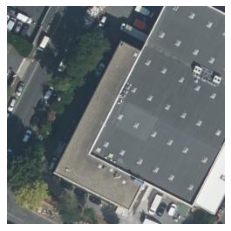

In [18]:
image = Image.open("test.jpg")
array = np.array(image)
saved_model = load_model(name_model)
testpred = saved_model.predict(array[None,:,:],verbose=1)
print(testpred)
plt.imshow(array)
plt.axis("off")
plt.show()

In [17]:
array = load_image(657810,6867200)
im = Image.fromarray((array*255).astype('uint8'), 'RGB')
saved_model = load_model(name_model)
im_array = np.asarray(im)
testpred = saved_model.predict(im_array[None,:,:],verbose=1)
print(testpred)

Execution time of load_image: 0.25432 seconds
1/1 [==============================] - 3s 3s/step
[[3.3340246e-05 9.9996662e-01]]


In [19]:
array = load_image(657810,6867200)
saved_model = load_model(name_model)
testpred = saved_model.predict(array[None,:,:],verbose=1)
print(testpred)

Execution time of load_image: 0.25516 seconds
1/1 [==============================] - 3s 3s/step
[[2.9269313e-17 1.0000000e+00]]


Execution time of full_load: 3.06647 seconds


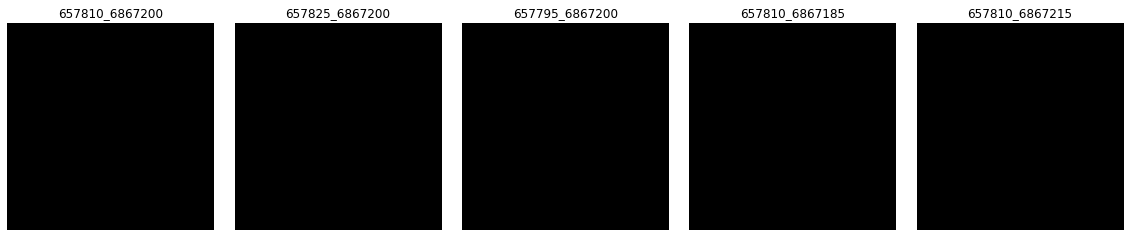

In [7]:
# im = load_image(657810,6867200)
names,images = full_load(657810,6867200,100)

plota_load(names,images)

### Inference on images
Loading model

Loop on all old predictions

In [34]:
def loop():
    # Loading old predictions
    df_old_pred = pd.read_csv(path_old_pred,sep=";")
    # Drop rows where predictions < 0.5
    df_old_pred = df_old_pred[df_old_pred['predictions'] >= 0.9]
    df_old_pred.drop(inplace=True,columns=["paths_tuiles"])
    print("C'est parti pour {} images".format(len(df_old_pred)))
    # Creating new dataframe to store results
    df_results = pd.DataFrame()
    # Loading model
    saved_model = load_model(name_model)
    i = 0
    for index, row in df_old_pred.iterrows():
        names,images = full_load(row["Xmin"],row["Ymin"],shift,img_size,resolution,raster)
        #plota_load(names,images)
        predictions = saved_model.predict_on_batch(images)
        #print(predictions)
        df_results = df_results.append(predictions_to_dataframe(names,predictions),ignore_index=True)
        i += 1
        # if i == 2:
        #     break
        if i%200 == 1 :
            print(i)
    df_results.to_csv(path_results,index=False,sep=";")
    return df_results

In [35]:
# On est à  secondes par image
df = loop()

C'est parti pour 2694 images
1
201
401
601
801
1001
1201
1401
1601
1801
2001
2201
2401
2601


In [36]:
df

,names,Xmin,Ymin,Xmax,Ymax,labels,predictions,Mean_predictions
0,619575_6819525_619650_6819600,619575,6819525,619650,6819600,chantier_plein,0.94,0.842
1,619590_6819525_619665_6819600,619590,6819525,619665,6819600,chantier_plein,0.99,0.842
2,619560_6819525_619635_6819600,619560,6819525,619635,6819600,chantier_plein,0.97,0.842
3,619575_6819510_619650_6819585,619575,6819510,619650,6819585,chantier_plein,0.93,0.842
4,619575_6819540_619650_6819615,619575,6819540,619650,6819615,chantier_vide,0.38,0.842
...,...,...,...,...,...,...,...,...
13465,668550_6842925_668625_6843000,668550,6842925,668625,6843000,chantier_plein,0.88,0.708
13466,668565_6842925_668640_6843000,668565,6842925,668640,6843000,chantier_vide,0.47,0.708
13467,668535_6842925_668610_6843000,668535,6842925,668610,6843000,chantier_plein,0.66,0.708
13468,668550_6842910_668625_6842985,668550,6842910,668625,6842985,chantier_plein,0.93,0.708


In [49]:
original_pred = df[::5]
print(original_pred["predictions"].mean())
print(original_pred["Mean_predictions"].mean())
ratisseur = original_pred[original_pred["Mean_predictions"]>0.5]

0.9669789671897888
0.9204949736595154


In [55]:
ratisseur

,names,Xmin,Ymin,Xmax,Ymax,labels,predictions,Mean_predictions
0,619575_6819525_619650_6819600,619575,6819525,619650,6819600,chantier_plein,0.94,0.842
5,622800_6826500_622875_6826575,622800,6826500,622875,6826575,chantier_plein,0.93,0.846
10,622875_6826500_622950_6826575,622875,6826500,622950,6826575,chantier_plein,0.96,0.872
15,623025_6814050_623100_6814125,623025,6814050,623100,6814125,chantier_plein,1.00,0.996
20,623175_6819300_623250_6819375,623175,6819300,623250,6819375,chantier_plein,0.99,0.902
...,...,...,...,...,...,...,...,...
13445,665925_6842475_666000_6842550,665925,6842475,666000,6842550,chantier_plein,0.89,0.730
13450,666075_6843675_666150_6843750,666075,6843675,666150,6843750,chantier_plein,1.00,1.000
13455,667350_6841500_667425_6841575,667350,6841500,667425,6841575,chantier_plein,0.96,0.796
13460,667350_6841575_667425_6841650,667350,6841575,667425,6841650,chantier_plein,1.00,0.958


Execution time of load_image: 0.58432 seconds


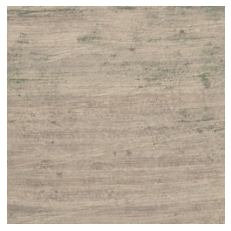

In [48]:
im = load_image(639750,6832050)
plt.imshow(im)
plt.axis("off")
plt.show()

In [43]:
original_pred[original_pred['predictions'] < 0.7].head(30)

,names,Xmin,Ymin,Xmax,Ymax,labels,predictions,Mean_predictions
95,628500_6807975_628575_6808050,628500,6807975,628575,6808050,chantier_vide,0.23,0.280
820,634500_6834600_634575_6834675,634500,6834600,634575,6834675,chantier_vide,0.42,0.292
1140,637200_6820275_637275_6820350,637200,6820275,637275,6820350,chantier_plein,0.62,0.518
1160,637275_6820125_637350_6820200,637275,6820125,637350,6820200,chantier_plein,0.68,0.496
1185,637350_6819900_637425_6819975,637350,6819900,637425,6819975,chantier_plein,0.69,0.380
1195,637350_6820050_637425_6820125,637350,6820050,637425,6820125,chantier_plein,0.66,0.794
1245,637500_6820050_637575_6820125,637500,6820050,637575,6820125,chantier_plein,0.56,0.508
2300,639675_6832050_639750_6832125,639675,6832050,639750,6832125,chantier_plein,0.66,0.618
2370,639750_6832050_639825_6832125,639750,6832050,639825,6832125,chantier_plein,0.62,0.832
2900,641025_6825450_641100_6825525,641025,6825450,641100,6825525,chantier_plein,0.66,0.428


In [51]:
original_pred

,names,Xmin,Ymin,Xmax,Ymax,labels,predictions,Mean_predictions
0,619575_6819525_619650_6819600,619575,6819525,619650,6819600,chantier_plein,0.94,0.842
5,622800_6826500_622875_6826575,622800,6826500,622875,6826575,chantier_plein,0.93,0.846
10,622875_6826500_622950_6826575,622875,6826500,622950,6826575,chantier_plein,0.96,0.872
15,623025_6814050_623100_6814125,623025,6814050,623100,6814125,chantier_plein,1.00,0.996
20,623175_6819300_623250_6819375,623175,6819300,623250,6819375,chantier_plein,0.99,0.902
...,...,...,...,...,...,...,...,...
13445,665925_6842475_666000_6842550,665925,6842475,666000,6842550,chantier_plein,0.89,0.730
13450,666075_6843675_666150_6843750,666075,6843675,666150,6843750,chantier_plein,1.00,1.000
13455,667350_6841500_667425_6841575,667350,6841500,667425,6841575,chantier_plein,0.96,0.796
13460,667350_6841575_667425_6841650,667350,6841575,667425,6841650,chantier_plein,1.00,0.958


In [56]:
ratisseur.to_csv("preds_moy.csv",sep=";",index=False)

In [9]:

for x in range(2):
    for y in range(2):
        Coordx = 657810+x*img_size*resolution
        Coordy = 6867200+y*img_size*resolution
        arr_img = arcpy.RasterToNumPyArray(raster,arcpy.Point(Coordx,Coordy),img_size,img_size)
        arr_img = arr_img.T
        print(arr_img.shape)
        #im.save(path_to_save+"images_2021/"+str(Coordx)+"_"+str(Coordy)+".jpg")

(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)


In [10]:
df_old_pred = pd.read_csv(path_old_pred,sep=";")
df_old_pred.head(20)

,paths_tuiles,names,Xmin,Ymin,Xmax,Ymax,labels,predictions
0,H:\Datasets\ortho_piscines\ortho2021_500px\tui...,619500_6819000_619575_6819075,619500,6819000,619575,6819075,chantier_vide,0.00
1,H:\Datasets\ortho_piscines\ortho2021_500px\tui...,619500_6819075_619575_6819150,619500,6819075,619575,6819150,chantier_vide,0.00
2,H:\Datasets\ortho_piscines\ortho2021_500px\tui...,619500_6819150_619575_6819225,619500,6819150,619575,6819225,chantier_vide,0.00
3,H:\Datasets\ortho_piscines\ortho2021_500px\tui...,619500_6819225_619575_6819300,619500,6819225,619575,6819300,chantier_vide,0.00
4,H:\Datasets\ortho_piscines\ortho2021_500px\tui...,619500_6819300_619575_6819375,619500,6819300,619575,6819375,chantier_vide,0.00
5,H:\Datasets\ortho_piscines\ortho2021_500px\tui...,619500_6819375_619575_6819450,619500,6819375,619575,6819450,chantier_vide,0.00
6,H:\Datasets\ortho_piscines\ortho2021_500px\tui...,619500_6819450_619575_6819525,619500,6819450,619575,6819525,chantier_vide,0.00
7,H:\Datasets\ortho_piscines\ortho2021_500px\tui...,619500_6819525_619575_6819600,619500,6819525,619575,6819600,chantier_vide,0.00
8,H:\Datasets\ortho_piscines\ortho2021_500px\tui...,619500_6819600_619575_6819675,619500,6819600,619575,6819675,chantier_vide,0.00
9,H:\Datasets\ortho_piscines\ortho2021_500px\tui...,619500_6819675_619575_6819750,619500,6819675,619575,6819750,chantier_vide,0.08


In [11]:
print(tf.__version__)

2.9.0
